# Esercitazione 3
### Laboratorio di Simulazione Numerica

Il materiale relativo all'esercitazione tre è suddiviso come segue nella cartella `Lab_03`: i codici sono raccolti nella cartella `3.1` corrispondente alla consegna dell'esercitazione; i risultati relativi agli esercizi svolti sono raccolti nella cartella `Results`;

---

Il Jupyter Notebook è organizzato come segue:
- 3.0 caricamento dei pacchetti e introduzione;
- 3.1 stima del prezzo di vendita/acquisto di opzioni CALL e PUT europee;

## 3.0 - caricamento dei pacchetti e introduzione

In questa esercitazione ci occupiamo di stimare tramite metodi MC il prezzo più consono per acquistare/vendere alcuni semplici derivati finanziari: _opzione CALL europea, opzione PUT europea_. Le opzioni, come già detto, sono dei derivati, ossia dei prodotti finanziari il cui valore è dipendente dal prezzo di un bene di riferimento. Per farlo, ho definito la classe `EconoPhysics`, contenente alcuni metodi che spiegherò nel corso di questo notebook.

---

Nello specifico, un'opzione è un contratto finanziario che viene venduto da una parte (_writer_) e comprato da un'altra (_holder_). Chi ne è in possesso ha il diritto di esercitare una specifica azione (vendita o acquisto) di un certo bene ad un certo tempo $T$ e ad un certo prezzo $K$, detto _strike price_, che viene stabilito nel momento in cui si stipula l'accordo tra le parti. In sostanza, il _writer_ è obbligato a comprare o vendere quel bene ad un certo prezzo __se__ l'_holder_ lo richiede. L'aspetto che a questo punto diventa cruciale nella stipula del contratto di vendita/acquisto dell'opzione è l'accordo sul prezzo $O$ dell'opzione stessa: infatti chi la vende ha interesse di guadagno istantaneo, chi la compra è interessato ai guadagni sul più lungo termine dell'operazione. Vediamo più nel dettaglio gli aspetti delle due opzioni per cui siamo interessati a stimare il prezzo $O$; nelle opzioni europee il _writer_ assicura all'_holder_ il diritto di:
- __call:__ acquistare dal _writer_ un bene che al momento della stipula del contratto ha un prezzo $S(t)$ ad un prezzo $K$ in un certo tempo $T$ accordato;
- __put:__ vendere al _writer_ questo stesso bene al prezzo $K$, al tempo $T$.

Naturalmente l'_holder_ eserciterà il suo privilegio soltanto se potrà trarne profitto al tempo $T$. Definendo con $C, P$ il vantaggio accumulato dall'_holder_ tramite un'opzione rispettivamente _call_ e _put_ essi sono quantificabili nel modo seguente:
- $C(S,T)=\max (S(T)-K, 0)$
- $P(S,T)=\min (0, K-S(T))$

---

L'evoluzione temporale del prezzo di un bene $S(t)$ può essere trattata come un moto browniano geometrico (GBM). Sotto alcune ipotesi precise (mercato fluido, ecc.) esiste una soluzione analitica che ci permette di conoscere il valore delle funzioni $C$ e $P$ a qualsiasi tempo $t<T$. Si tratta delle soluzioni di  Black-Scholes, che ci sono state fornite in modo esplicito a lezione e che, nel mio codice, possono essere ottenute eseguendo il metodo `save_Black_Scholes_solution` della classe `EconoPhysics`. Ho utilizzato queste soluzioni come valore teorico con cui cui confrontare i risultati delle mie simulazioni.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(font_scale=1.7, style='whitegrid') 

In [2]:
dir_cal = np.loadtxt("Results/direct_opt.dat")        # stima direttamente da S(T)
step_cal = np.loadtxt("Results/bystep_opt.dat")       # stima step-by-step
sol = np.loadtxt("Results/solutions.dat")             # soluzioni di Black-Scholes

## 3.1 - stima del prezzo di vendita/acquisto di opzioni call e put europee

Quando si effettua una simulazione di un prezzo di un certo bene $S(t)$ si arriva, al termine del procedimento, ad ottenere $S(T)$. A questo punto, per calcolare il guadagno accumulato in questo tempo, è necessario moltiplicare tale valore per un fattore $e^{-rT}$, dove $r$ corrisponde al tasso di interesse (che una banca ci garantirebbe nel continuo) legato al deposito di una certa somma di denaro a tempo $t=0$.

Per eseguire le simulazioni tramite cui abbiamo stimato il prezzo di acquisto/vendita delle opzioni abbiamo trattato l'evoluzione di $S(t)$ come un $GBM(r,\sigma^2)$, ossia un moto browniano geometrico con _drift_ $r$ e volatilità $\sigma^2$. Nel farlo, abbiamo utilizzato due approcci diversi:
1. abbiamo stimato i valori di $C[S(0),t=0]$ e $P[S(0),t=0]$ campionando direttamente il prezzo di asset finale $S(T)$, dunque generando un unico passo $W(T)$ estratto dalla distribuzione $\mathcal{N}(0,T)$ e poi moltiplicando il risultato ottenuto per $e^{-rT}$;
2. abbiamo stimato gli stessi valori campionando un $GBM(r, \sigma^2)$ su un cammino discreto, dividendo l'intervallo temporale $[0,T]$ in cento passi gaussiani $Z_i$ estratti dalla $\mathcal{N}(0,1)$. Anche in questo caso otteniamo i valori di $C$ e $P$ moltiplicando il risultato per $e^{-rT}$.

---

Questi due metodi, che spiegherò meglio poco più avanti, sono implementati all'interno della classe `EconoPhysiscs`, la quale esegue il primo o il secondo nel caso in cui la variabile `method` venga inizializzata come `"direct"` o `"step by step"`. Anche in questo caso ricaviamo la stima del valore di $P$ e $C$ tramite il metodo delle medie a blocchi, introdotto nelle esercitazioni precedenti. Nel caso di queste simulazioni il metodo `get_measure` fornisce la stima di $C$ e $P$ calcolata in modo opportunamente stabilito a seconda del valore selezionato di `method`. Tutti i risultati presentati in seguito sono stati ottenuti eseguendo $M=10^5$ realizzazioni suddivise in $N=100$ blocchi.

---

Nel corso dell'esercizio abbiamo considerato: $S(0)=100,\,\,K=100,\,\,t_0=0,\,\,T=1,\,\,r=0.1,\,\,\sigma=0.25$.

### 3.1.1 Metodo diretto

In questa prima simulazione, come già detto, partiamo da un prezzo $S(0)$ e "saltiamo" al prezzo finale con un passo unico $W(T)$. Inserendo a questo punto l'incremento prodotto nell'espressione: $$ S(T) = S(0)\texttt{exp}\biggl[\biggl(r-\frac{1}{2}\sigma^2\biggr)T+\sigma W(T) \biggr], $$ siamo in grado di stimare $C$ e $P$ nel modo seguente: $$ C[S(0),0]=e^{-rT}\max[0, S(T)-K], \qquad \qquad P[S(0),0]=e^{-rT}\min [0, K-S(T)].  $$

#### Risultati ottenuti

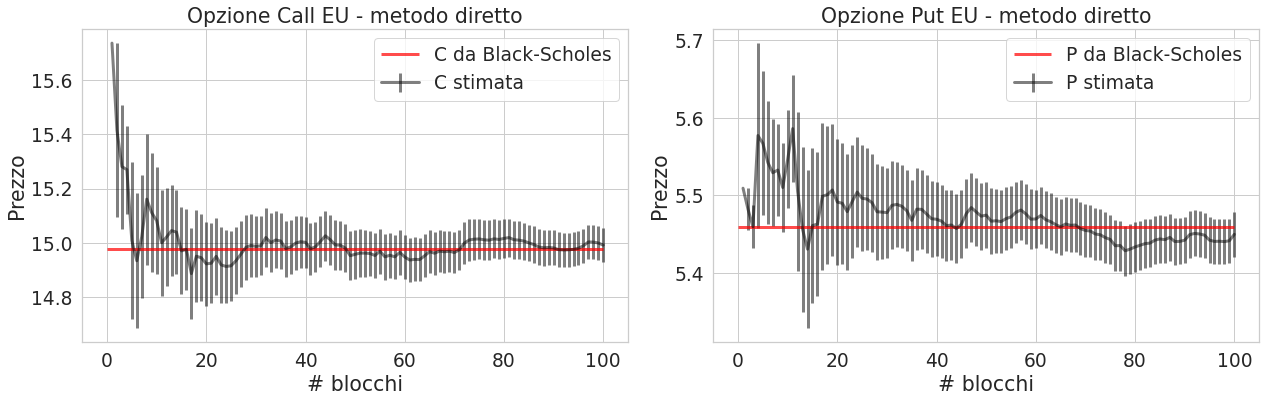

In [3]:
x = np.arange(1,101)

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.title("Opzione Call EU - metodo diretto")
plt.errorbar(x, dir_cal.T[0], yerr=dir_cal.T[1], color='black', alpha=0.5, linewidth=3, label='C stimata')
plt.hlines(sol[0], 0, 100, color='red', alpha=0.7, linewidth=3, label='C da Black-Scholes')
plt.xlabel("# blocchi")
plt.legend()
plt.ylabel("Prezzo")

plt.subplot(1,2,2)
plt.title("Opzione Put EU - metodo diretto")
plt.errorbar(x, dir_cal.T[2], yerr=dir_cal.T[3], color='black', alpha=0.5, linewidth=3, label='P stimata')
plt.hlines(sol[1], 0, 100, color='red', alpha=0.7, linewidth=3, label='P da Black-Scholes')
plt.xlabel("# blocchi")
plt.legend()
plt.ylabel("Prezzo")

plt.tight_layout()
plt.show()

__Figura 1:__ a sinistra, andamento della stima tramite metodo blocking del valore di $C[S(0),0]$. A destra, stima del valore di $P[S(0),0]$. Entrambi i valori calcolati presentano un'incertezza che li rende compatibili con i valori teorici forniti dalle soluzioni di Black-Scholes. 

### Metodo iterativo

Per eseguire questa seconda tecnica siamo partiti da un prezzo iniziale $S(0)$. Abbiamo inoltre, per cento volte, campionato le variabili $Z_i\sim \mathcal{N}(0,1)$, con $i=1,...,100$. Abbiamo inoltre suddiviso l'intervallo temporale $[0,T]$ in cento intervalli, scanditi dai valori di tempo: $\{0, .., t_i, t_{i+1}, .., T \}$. In questo modo abbiamo calcolato la sequenza temporale dei valori di $S(t)$ come: $$ S(t_{i+1})=S(t_i)\texttt{exp}\biggl[\biggl(r-\frac{1}{2}\sigma^2 \biggr)(t_{i+1}-t_i)+\sigma Z_{i+1}\sqrt{t_{i+1}-t_i} \biggr]. $$ 
Una volta eseguiti cento passi si ottiene dunque il valore stimato per $S(T)$. A questo punto per ricavare i desiderati $C[S(0),0]$ e $P[S(0),0]$ si operano le medesime trasformazioni spiegate in precedenza.

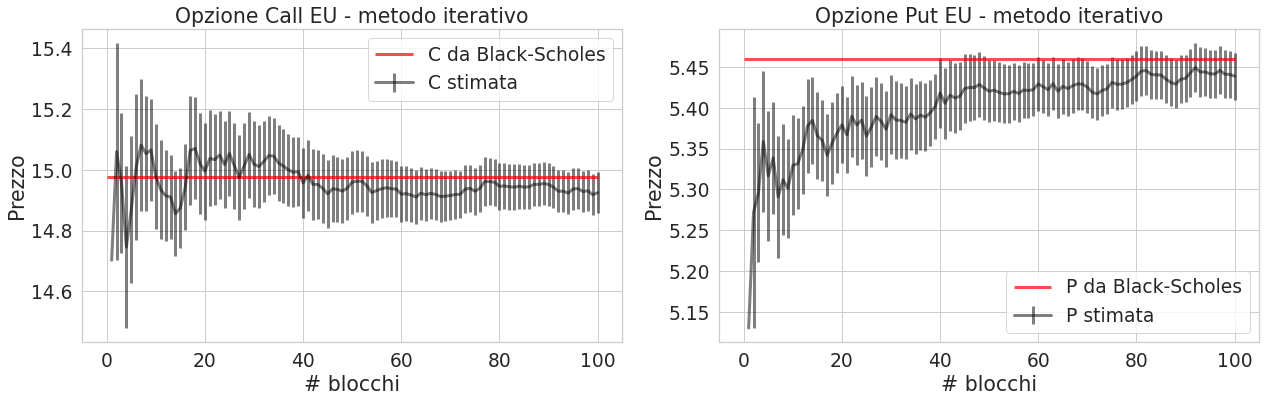

In [4]:
x = np.arange(1,101)

plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
plt.title("Opzione Call EU - metodo iterativo")
plt.errorbar(x, step_cal.T[0], yerr=step_cal.T[1], color='black', alpha=0.5, linewidth=3, label='C stimata')
plt.hlines(sol[0], 0, 100, color='red', alpha=0.7, linewidth=3, label='C da Black-Scholes')
plt.xlabel("# blocchi")
plt.ylabel("Prezzo")
plt.legend()

plt.subplot(1,2,2)
plt.title("Opzione Put EU - metodo iterativo")
plt.errorbar(x, step_cal.T[2], yerr=step_cal.T[3], color='black', alpha=0.5, linewidth=3, label='P stimata')
plt.hlines(sol[1], 0, 100, color='red', alpha=0.7, linewidth=3, label='P da Black-Scholes')
plt.xlabel("# blocchi")
plt.ylabel("Prezzo")
plt.legend()

plt.tight_layout()
plt.show()

__Figura 2:__ a sinistra, andamento della stima tramite metodo blocking del valore di $C[S(0),0]$. A destra, stima del valore di $P[S(0),0]$. Entrambi i valori calcolati con il metodo iterativo presentano un'incertezza che li rende compatibili con i valori teorici forniti dalle soluzioni di Black-Scholes. 

In [8]:
print("RISULTATI FINALI EU CALL OPT")
print("--------------------------------------------------------------------------")
print("Soluzione di Black-Scholes: ", sol[0])
print("Misura finale con metodo diretto: ", dir_cal[99][0], " avente incertezza: ", dir_cal[99][1])
print("Misura finale con metodo iterativo: ", step_cal[99][0], " avente incertezza: ", step_cal[99][1])
print("\n")
print("RISULTATI FINALI EU PUT OPT")
print("--------------------------------------------------------------------------")
print("Soluzione di Black-Scholes: ", sol[1])
print("Misura finale con metodo diretto: ", dir_cal[99][2], " avente incertezza: ", dir_cal[99][3])
print("Misura finale con metodo iterativo: ", step_cal[99][2], " avente incertezza: ", step_cal[99][3])

RISULTATI FINALI EU CALL OPT
--------------------------------------------------------------------------
Soluzione di Black-Scholes:  14.9758
Misura finale con metodo diretto:  14.9914  avente incertezza:  0.0615667
Misura finale con metodo iterativo:  14.9245  avente incertezza:  0.0679725


RISULTATI FINALI EU PUT OPT
--------------------------------------------------------------------------
Soluzione di Black-Scholes:  5.45953
Misura finale con metodo diretto:  5.44982  avente incertezza:  0.0292296
Misura finale con metodo iterativo:  5.4385  avente incertezza:  0.0288574


Come possiamo vedere i risultati ottenuti sono statisticamente equivalenti.

Riporto un'immagine dell'output delle funzioni `print` nel caso in cui GitHub non mostri gli output.

---

<img src="lab03.png">

---